**PROYECTO FINAL**
# MATERIA: SISTEMA DE COMUNICACIONES
![logo-unt.png](logo-unt.png)

ALUMNOS:

*   REYES, MAXIMILIANO
*   PEREYRA, FAUSTO

---

---


# LIBRERIAS

In [2]:
##--->DESCOMENTAR SI SE TRABAJA DESDE GOOGLE COLAB<---

#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
#import math
from scipy.fftpack import fft, fftfreq
from numpy.fft.helper import fftshift
from scipy import signal
import matplotlib.image as mpimg
#from IPython.display import HTML 
from matplotlib.animation import FuncAnimation

# FUNCIONES

In [2]:
#TIPOS DE CODIGO
def Barker(fc,AB,PRF):
    print('Barker 7')
    Cod_Barker = np.array([[1],[1],[1],[0],[0],[1],[0]]) # Araay (7,1) no es array 1D
    [senal,t] = Senal_BPSK(Cod_Barker,fc,AB,PRF)
    return [senal,t]

def Barker7(fc,AB,PRF):
    print('Barker 11')
    Cod_Barker_7 = np.array([[1],[1],[1],[0],[0],[0],[1],[0],[0],[1],[0]])
    [senal,t] = Senal_BPSK(Cod_Barker_7,fc,AB,PRF)
    return [senal,t]

def Barker13(fc,AB,PRF):
    print('Barker 13')
    Cod_Barker_13 = np.array([[1],[1],[1],[1],[1],[0],[0],[1],[1],[0],[1],[0],[1]])
    [senal,t] = Senal_BPSK(Cod_Barker_13,fc,AB,PRF)
    return [senal,t]

def Complem_1(fc,AB,PRF):
    Cod_complem_1 = np.array([[1],[1],[0],[1],[1],[1],[1],[0],[1],[0],[0],[0],[1],[0],[1],[1]])
    [senal,t] = Senal_BPSK(Cod_complem_1,fc,AB,PRF)
    return [senal,t]

def Complem_2(fc,AB,PRF):
    Cod_complem_2 = np.array([[1],[1],[0],[1],[1],[1],[1],[0],[0],[1],[1],[1],[0],[1],[0],[0]])
    [senal,t] = Senal_BPSK(Cod_complem_2,fc,AB,PRF)
    return [senal,t]

#FUNCIONES PARA GENERAR SEÑALES

def Forma_Onda_Tx(Tipo_radar,Tipo_cod,N,AB,PRF,T,fc):
    """
        Genera la serie temporal Tx, de acuerdo al Tipo de Radar (CW o Pulsado)
        -----------------------------------------------------------------------

        array(n,2)  complex Forma_Onda_Tx( string Tipo_radar, string Tipo_cod, int N, float AB, float PRF, float T, float fc)
        Entrada:
            Tipo_radar: "Pulsado"  "CW"
            Tipo_cod:"Complementario"  "Barker"  "Frank "
            N: Num intergraciones
            AB: Ancho de Banda
            PRF: Frecuencia de Repeticion de Pulso
            T: Ancho del pulso
            fc: Frecuencia de portadora
        Salida:
            senal: muestras de la Serie Temporal   (array 1D)
            t: base de tiempo, arrancando con un determinado offset (array 1D)
        -----------------------------------------------------------------------
    """

    senal = []
    t = []
    ofset = 0
    if(Tipo_radar == 'LFM'):
        fase = 0
        [aux, auxt] = Generacion_LFM(fc, T,  AB, PRF, fase)
        for i in range(N):
            senal = np.hstack((senal,aux))
            t = np.append(np.array(t), auxt + ofset)
            ofset = np.array(t)[-1]

    elif(Tipo_radar == 'Pulse_Cod'):
        [aux, auxt]= Generacion_Pulso(Tipo_cod, fc, AB, T, PRF)
        for i in range(N):
            senal = np.hstack((senal,aux))
            t = np.append(np.array(t), auxt + ofset)
            ofset = np.array(t)[-1]
    else:
        print("\n Error: opcion No valida. Tipo de Radar\n")
    fs = 1/(t[1]-t[0])
    return senal,t, fs

def Generacion_LFM(fc, T, AB, PRF, fase):
    """
        Genera una serie temporal, correspondiente a un señal LFM-UP
        -----------------------------------------------------------------------
        array(n,2) complex Generacion_LFM(float fc, float T, float AB, int fase)
        Entrada:
            fc: Frecuencia de portadora [Hz]
            T: Ancho del pulso [s]
            AB: Ancho de Banda [Hz]
            PRF :Frec de Preteticon de Pulso [Hz]
            fase: Fase Inicial [rad]
        Salida:
            senal: muestras de la Serie Temporal LFM   (array 1D)
            t: base de tiempo, arrancando con un determinado offset   (array 1D)
        -----------------------------------------------------------------------
    """

    fmax = fc
    if (fc == 0): fmax = AB   # fmax = AB/2
    fs = 16*fmax
    num_muestras = int (T*fs)

    f_inicial = 0
    f_final = AB
    times_s = np.linspace(0, T, num_muestras) # Chirp tiempo.
    k = (f_final - f_inicial) / T # Chirp rate.
    sweepFreqs_Hz = (fc + f_inicial + k * times_s) * times_s
    senal = np.exp(1j* (fase + 2 * np.pi * sweepFreqs_Hz))

    t = np.linspace(0, (num_muestras - 1) * (1/fs), num_muestras) # Intervalo de tiempo en segundos

    if (PRF != 0):
        PRP = 1/PRF
        ts = 1/fs
        t_recepcion = np.arange(t[-1],int((PRP-T)/ts)*ts,ts)
        recepcion = np.zeros(np.size(t_recepcion))
        t = np.append(t,t_recepcion)
        senal = np.append(senal,recepcion)

    return senal,t, fs




def Generacion_Pulso(Tipo_cod,fc,AB,T,PRF):
    """
        Se genera señales BPSK codificadas de una determinada duracion, en funcion del codigo elegido.
        -----------------------------------------------------------------------
        array(n,2) complex Generacion_Pulso(string Tipo_Cod, float fc, float AB, float T, float PRF)
        Entrada:
            Tipo_Cod: Complemetario/Barker7,11,13/Frank
            fc: Frecuencia de Portadora [Hz]
            AB: Ancho de Banda [Hz]
            T: Ancho de Pulso [s]
            PRF: Frecuencia de Repeticion de Pulso [Hz]
        Salida:
            senal: muestras de la Serie Temporal PBSK Codificada
            t: base de tiempo
            fs: Frec muestrep
        -----------------------------------------------------------------------
    """

    senal = []
    if(Tipo_cod == 'Complem_1'):
        [senal, t] = Complem_1(fc,AB,PRF)

    elif(Tipo_cod == 'Complem_2'):
        [senal, t] = Complem_2(fc,AB,PRF)

    elif(Tipo_cod == 'Barker_7'):
        [senal, t] = Barker(fc,AB,PRF)

    elif(Tipo_cod == 'Barker_11'):
        [senal, t] = Barker7(fc,AB,PRF)

    elif(Tipo_cod == 'Barker_13'):
        [senal, t] = Barker13(fc,AB,PRF)

    else:
        print("\n Error: opcion No valida. Tipo de Codigo\n")

    return senal,t

def Senal_BPSK(codigo,fc,AB,PRF):
    """
        Genera una serie temporal, correspondiente a un señal BPSK-Codificda

        -----------------------------------------------------------------------
        array(n,2) complex Senal_BPSK(array int codigo, float fc, float AB)

        Entrada:
            codigo: Codigo modulador
            fc: Frecuencia de portadora [Hz]
            AB: Ancho de Banda [Hz]
            PRF: Frecuencia de repeicion de pulso [Hz]
        Salida:
            senal: muestras de la Serie Temporal PBSK Codificada  (array 1D)
            tiempo: base de tiempo, arrancando con un determinado offset  (array 1D)
            fs: Frec. de muestreo
        -----------------------------------------------------------------------
    """
    Nbits = np.size(codigo,0) # num bits
    print("\n EL VALOR DE Nbits ES:", str(Nbits))
    T = round(Nbits*(1/AB),4) # Ancho del pulso [s]
    #agregado para saber T
    #print("\n EL VALOR DE T ES:", str(T))
    fmax = fc
    #fmax=AB #AGREGADO
    if (fc == 0): fmax = AB
    #fs = 16*fmax
    fs=1e6 #agrego
    #print("\n EL VALOR DE fs ES:", str(fs))
    N = int(T*fs) # Num de muestras del pulso
    #print("\n EL VALOR DE N ES:", str(N))
    Ns = int(fs/AB)  # Num de muestras por bit
    #print("\n EL VALOR DE Ns ES:", str(Ns))

    #CAMBIO DE ORDEN t Y cod
    cod = np.tile(codigo*2-1,(1,Ns))

    t = np.linspace(0,  (N - 1) * (1/fs),len(cod.ravel()) ) # t = r_[0.0:N]/fs ###AGREGUE EL len(cod.ravel())
    #t = np.linspace(0, (1/fs),int(T) )
    #t = np.linspace(0, (N - 1) * (1/fs),N )
    #print("\n LA LONGITUD DE t ES:", str(len(t)))


    #print("\n LA LONGITUD DE cod ES:", str(len(cod.ravel())))
    senal = np.multiply(cod.ravel(),np.exp(1j*2*np.pi*fc*t))

    if (PRF != 0):
        PRP = 1/PRF
        ts = 1/fs
        t_recepcion = np.arange(t[-1],int((PRP-T)/ts)*ts,ts)
        recepcion = np.zeros(np.size(t_recepcion))
        t = np.append(t,t_recepcion)
        senal = np.append(senal,recepcion)


    return senal,t

def Ruido(Pn, Sigma_Ruido, PRF, fc, AB, T, fs):
    """
    Genera la serie temporal de Ruido de una determinada duracion con una PDF Log-Normal.

    --------------------------------------------------------------------------
    array(n,2) coplex Ruido (float Pn,float Sigma_Ruido, float PRF, float fc, float AB, float T,float fs)

    Entradas
        Pn: Potencia media de Ruido [W]
        Sigma_Ruido: Desviacion Standar de Pn [W]
        PRF: Frec de Repeticion de Pulso [Hz]
        fc: Frec. de Portadora [Hz]
        AB: Ancho de Banda [Hz]
        T: Duracion del Pulso [s]
        fs: Frecuencia de muestreo[Hz]
    Salidas
        senal: muestras de la Serie Temporal
        t: base de tiempo, arrancando con un determinado offset
    --------------------------------------------------------------------------
    """

    Duracion = T
    if (PRF != 0): Duracion = (1/PRF - T)

    fmax = fc
    if (fc == 0): fmax = AB
    fs = 16*fmax

    N = int(Duracion*fs) # Num de muestras del pulso

    u_Ruido = math.log(Pn) - ((Sigma_Ruido**2)/2) # u = media
    senal = np.random.lognormal(u_Ruido,Sigma_Ruido,N)
    senal = (senal + 1j*senal)
    t = np.linspace(0, (N - 1) * (1/fs), N)

    return [senal, t]

def RCS(RCS,fc,AB,T,fsam, N, PDF):
    """
        Genera los valores RCS asociado al objetivo durante un determinado intervalo.
        Con una dada PDF
        -----------------------------------------------------------------------
        array complex Eco(float RCS, float fc, float AB, float T, float N, string PDF)
        Entrada:
            RCS: Valor medio de RCS de un objetivo [veces]
            fc: Frecuencia de Portadora [Hz]
            AB: Ancho de Banda [Hz]
            T: Ancho de Pulso [s]
            PDF: Funcion de Distribuacion de Probabilidad Swerling I, II ,III ,IV
        Salida:
            senal: muestras del valor RCS
            t: base de tiempo
        -----------------------------------------------------------------------
    """

    #Peco = Ptx + Gtx - Atte + RCS - attes + Grx


    Duracion = T
    fmax = fc
    if (fc == 0): fmax = AB
    fs = 16*fmax

    N = int(Duracion*fs) # Num de muestras del pulso

    if (PDF == "Swerling I" or PDF == "Swerling II"):
        u = (RCS/2) # u = media
        senal = (np.random.gamma(u,2,N)) # chi cuadrado es un caso especial de la gamma
        t = np.linspace(0, (N - 1) * (1/fs), N)

    elif (PDF == "Swerling III" or PDF == "Swerling IV"):
        escala = np.sqrt(2 / np.pi) * RCS # escala = sigma*sqrt(pi/2),  sigma = media
        senal = np.random.rayleigh(escala, N)
        t = np.linspace(0, (N - 1) * (1/fs), N)

    else:
        print("\n Error: opcion No valida. Tipo de Distribucion de RCS\n")

    return [senal, t]

def Eco_Signal(noise, t, signal, delay, fs):

    samples_delay = int(delay*fs)
    noise[samples_delay:samples_delay + len(signal)] += signal

    senal = noise
    return senal,t

#FUNCIONES PARA EL PROCESAMIENTO DE SEÑALES
def rrcosfilter(N, alpha, Ts, Fs):
    """
    Genera el filtro Raiz Coseno alzado, Filtro FIR.

    Parameters
    ----------
    N : int
        Length of the filter in samples.
    alpha : float
        Roll off factor (Valid values are [0, 1]).
    Ts : float
        Symbol period in seconds.
    Fs : float
        Sampling Rate in Hz.
    Returns
    ---------
    time_idx : 1-D ndarray of floats
        Array containing the time indices, in seconds, for
        the impulse response.
    h_rrc : 1-D ndarray of floats
        Impulse response of the root raised cosine filter.
    """

    T_delta = 1/float(Fs)
    time_idx = ((np.arange(N)-N/2))*T_delta
    sample_num = np.arange(N)
    h_rrc = np.zeros(N, dtype=float)

    for x in sample_num:
        t = (x-N/2)*T_delta
        if t == 0.0:
            h_rrc[x] = 1.0 - alpha + (4*alpha/np.pi)
        elif alpha != 0 and t == Ts/(4*alpha):
            h_rrc[x] = (alpha/np.sqrt(2))*(((1+2/np.pi)* \
                    (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        elif alpha != 0 and t == -Ts/(4*alpha):
            h_rrc[x] = (alpha/np.sqrt(2))*(((1+2/np.pi)* \
                    (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        else:
            h_rrc[x] = (np.sin(np.pi*t*(1-alpha)/Ts) +  \
                    4*alpha*(t/Ts)*np.cos(np.pi*t*(1+alpha)/Ts))/ \
                    (np.pi*t*(1-(4*alpha*t/Ts)*(4*alpha*t/Ts))/Ts)

    return time_idx, h_rrc

def Correlacion(senal_1,senal_2):
    """
    Realiza la funcion correlacion entre las senal_1 y senal_2

    array correlacion(array senal_1,array senal_2)

    Entradas:
             senal_1: vector de longitusd N (array 1D)
             senal_2: vector de longitud M (array 1D)
    Salidas:
             salida: vector que contiene la correlacion entre las señales de entradas.
             Tiene una longitud N + M -1  (array 1D)
    """

    salida = signal.convolve(senal_1,np.flip(senal_2.conjugate()),"full","auto")

    return salida

def FFT(y,n,dt):
    """
    Realiza la FFT de la señal y

    array(complex) FFT(array complex y,int n, float dt)

    Entradas:
             y: vector de longitud N (array 1D)
             n: Numero de muestras del vector y
             dt: intevalo de muestreo de la señal y
    Salidas:
             Y : resultado de FFT de y (array 1D)
             frec: Frecuencias asociadas a FFT(y)   (array 1D)
    """
    Y = fft(y) / n # Normalizada
    frec = fftfreq(n, dt) # Recuperamos las frecuencias
    return Y,frec



def graficar_t(t,y,title,color = None):

    if color is None: color = "b"
    else:color = color
    plt.plot(t*1e3,y,color,label=title)
    plt.xlabel('Tiempo (ms)'),plt.ylabel('Amplitud'),plt.grid()
    plt.legend()

def graficar_f(f,Y,Fc,AB):
    plt.vlines(f/1000, 0, np.abs(Y),'r')
    plt.xlim(-4*(Fc+AB)/1000,4*(Fc+AB)/1000)
    plt.xlabel('Frecuencia (kHz)'),plt.ylabel('Abs(Y)'),plt.grid()
    plt.vlines((Fc+AB/2)/1000, 0, 0.5,'g')
    plt.vlines((Fc-AB/2)/1000, 0, 0.5,'g')

def detect_peak(x, num_train, num_guard, rate_fa):
    """
    Detect peaks with CFAR algorithm.

    num_train: Number of training cells.
    num_guard: Number of guard cells.
    rate_fa: False alarm rate.
    """
    num_cells = x.size
    num_train_half = round(num_train / 2)
    num_guard_half = round(num_guard / 2)
    num_side = num_train_half + num_guard_half

    alpha = num_train*(rate_fa**(-1/num_train) - 1) # threshold factor
    print('valor de alpha: '+str(alpha))

    peak_idx = []
    
    for i in range(num_side, num_cells - num_side):

        if i != i - num_side + np.argmax(x[i - num_side:i + num_side+1]):
            continue

        sum1 = np.sum(x[i-num_side:i+num_side+1])
        sum2 = np.sum(x[i-num_guard_half:i+num_guard_half+1])
        p_noise = (sum1 - sum2) / num_train
        threshold = alpha * p_noise
        

        if x[i] > threshold:
            peak_idx.append(i)

    peak_idx = np.array(peak_idx, dtype=int)

    return peak_idx

def Detect_Peak_CA_CFAR(buffer_signal, guard_cell, noise_cell, Pfa):
    """
    Detect peaks with CA-CFAR algorithm.

    Input:
        buffer_signal:
            Signal where find the peaks  (1D).
        guard_cell:
            Number of guard cells (half).
        noise_cell:
            Number of cells in orden to calculate the average noise (half)
        Pfa:
            False alarm rate.

    Return:
        pos:
            Array with the positions of detected peaks   array (N,1)

    """

    buffer = np.append(np.zeros(noise_cell+guard_cell),buffer_signal)
    buffer = np.append(buffer,np.zeros((noise_cell+guard_cell)))

    buffer_mask = np.ones(2*(guard_cell + noise_cell) + 1)
    buffer_mask[noise_cell:noise_cell+(guard_cell*2+1)] = 0

    N = 2*noise_cell
    alpha = N*(Pfa**(-1/N) - 1)

    average_aux = np.convolve(buffer_mask,buffer,"full")/N
    average = average_aux[2*(guard_cell + noise_cell):2*(guard_cell + noise_cell)+len(buffer_signal)]
    threshod = alpha*average
    pos = np.where(buffer_signal > threshod)

    pos = np.array(pos, dtype=int)
    return pos.T

def Detect_peak2(buffer_signal,guard_cell,noise_cell,Pfa):

    
    buffer = np.append(np.zeros(noise_cell+guard_cell),buffer_signal)
    buffer = np.append(buffer,np.zeros((noise_cell+guard_cell)))

    buffer_mask = np.ones(2*(guard_cell + noise_cell) + 1)
    buffer_mask[noise_cell:noise_cell+(guard_cell*2+1)] = 0
    N = 2*noise_cell
    alpha = N*(Pfa**(-1/N) - 1) # threshold factor

    #umbral_cfar=[]

    pos = np.array([])
    for index in np.arange(len(buffer_signal)):

        buffer_muestral = buffer[index:index + len(buffer_mask)]

        averange = (buffer_muestral@buffer_mask)/N
        theshold = alpha*averange

        #umbral_cfar.append(theshold)

        if (buffer_signal[index] > theshold): 
            aux = int(index)
            pos = np.append(pos,aux)

    pos = pos[1:]
    pos = np.array(pos, dtype=int)
    return pos #umbral_cfar


def umbral2(buffer_signal,guard_cell,noise_cell,Pfa):


    buffer = np.append(np.zeros(noise_cell+guard_cell),buffer_signal)
    buffer = np.append(buffer,np.zeros((noise_cell+guard_cell)))

    buffer_mask = np.ones(2*(guard_cell + noise_cell) + 1)
    buffer_mask[noise_cell:noise_cell+(guard_cell*2+1)] = 0
    N = 2*noise_cell
    alpha = N*(Pfa**(-1/N) - 1) # threshold factor

    umbral_cfar=[]

  
    for index in np.arange(len(buffer_signal)):

        buffer_muestral = buffer[index:index + len(buffer_mask)]

        averange = (buffer_muestral@buffer_mask)/N
        theshold = alpha*averange

        umbral_cfar.append(theshold)

       
    return umbral_cfar

def cfar_2d(data, guard_cells, training_cells, threshold_factor):

    """
    Constant False Alarm Rate (CFAR) en 2 dimensiones
    
    Entradas:
    - `data`: Es una matriz bidimensional que representa los datos de entrada.
   - `guard_cells`: Número de celdas de guarda alrededor de la región de interés.
   - `training_cells`: Número de celdas utilizadas para estimar el nivel de ruido.
   - `threshold_factor`: Factor multiplicativo para calcular el umbral de detección.

    Proceso:
   - La función recorre cada celda dentro de la región de interés (excluyendo las celdas de guarda).
   - Para cada celda, calcula el nivel de ruido promedio utilizando las celdas de entrenamiento.
   - Luego, multiplica el nivel de ruido promedio por el factor de umbral para obtener el umbral de detección.
   - Si el valor de la celda actual es mayor que el umbral, se marca como un posible objetivo (asumiendo que hay un objeto presente).

    Resultado:
   - La función devuelve una matriz binaria (`cfar_result`) donde los valores de 1 indican posibles objetivos detectados y 0 representan áreas sin detección.

    """
    
    rows, cols = data.shape
    cfar_result = np.zeros((rows, cols))
    
    for i in range(training_cells + guard_cells, rows - training_cells - guard_cells):
        for j in range(training_cells + guard_cells, cols - training_cells - guard_cells):
            noise_level = 0
            num_training_cells = 0
            
            for k in range(i - training_cells - guard_cells, i + training_cells + guard_cells + 1):
                for l in range(j - training_cells - guard_cells, j + training_cells + guard_cells + 1):
                    if abs(k - i) > guard_cells or abs(l - j) > guard_cells:
                        noise_level += data[k, l]
                        num_training_cells += 1
            
            noise_level /= num_training_cells
            threshold = noise_level * threshold_factor
            
            if data[i, j] > threshold:
                cfar_result[i, j] = 1
    
    return cfar_result


def cfar_2d_umbral(data, guard_cells, training_cells, threshold_factor):
    rows, cols = data.shape
    cfar_umbral = np.zeros((rows, cols))
    
    for i in range(training_cells + guard_cells, rows - training_cells - guard_cells):
        for j in range(training_cells + guard_cells, cols - training_cells - guard_cells):
            noise_level = 0
            num_training_cells = 0
            
            for k in range(i - training_cells - guard_cells, i + training_cells + guard_cells + 1):
                for l in range(j - training_cells - guard_cells, j + training_cells + guard_cells + 1):
                    if abs(k - i) > guard_cells or abs(l - j) > guard_cells:
                        noise_level += data[k, l]
                        num_training_cells += 1
            
            noise_level /= num_training_cells
            threshold = noise_level * threshold_factor
            
            
            cfar_umbral[i, j] = threshold
    
    return cfar_umbral

# IMPORTAR DATOS DEL RADAR

In [3]:
#datos=open('/content/drive/MyDrive/Colab Notebooks/Matrix.txt') ## GOOGLE COLAB
datos=open('Matrix.txt') ## VISUAL STUDIO CODE
filas=datos.readlines()
listadepulsos=[]
exploracion=[]
for fila in filas:
    complejos=[]
    pulso=fila.split(" ")
    pulso.pop()
    if pulso[0]=="#":
        exploracion.append(listadepulsos)
        listadepulsos=[]
    else:
        for numero in pulso:
            complejos.append(complex(numero)) ##CAMBIAR A REAL O ABS
        listadepulsos.append(complejos)


# MATRIZ DE DATOS

GRAFICAR LA MATRIZ DE UNA EXPLORACION DETERMINADA Y CANTIDAD DE PULSOS DEFINIDOS

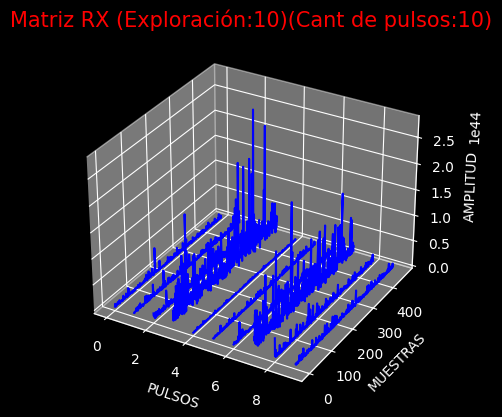

In [4]:
explr=10 #Define la exploracion
CantidadPulsos=10 #Grafica los n primeros pulsos

# Crear datos para los ejes x, y, z
ejx = range(400) # PULSOS
ejy = range(466) # MUESTRAS
ejz = exploracion[explr][:] # señales

# Configurar la figura y el eje 3D
plt.style.use("dark_background")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar
for i in range(CantidadPulsos):
    ax.plot(ejx[i]*np.ones_like(ejy), ejy, np.abs(ejz[i]),color='blue')

# Configurar etiquetas de los ejes
ax.set_xlabel('PULSOS')
ax.set_ylabel('MUESTRAS')
ax.set_zlabel('AMPLITUD')

# Mostrar la leyenda
#ax.legend()

plt.title('Matriz RX (Exploración:'+str(explr)+')'+'(Cant de pulsos:'+str(CantidadPulsos)+')',color='red',fontsize=15)
plt.gca().spines[['top', 'right']].set_visible(False)

# Mostrar el gráfico
plt.show()

GRAFICAR UN SOLO PULSO

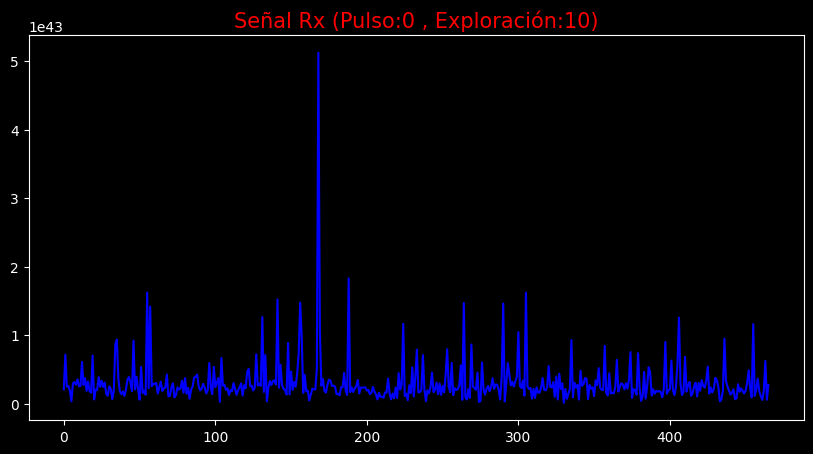

In [5]:
puls=0 #DEFINIR PULSO
expl=10  #DEFINIR EXPLORACION
y=exploracion[expl][puls]
x=range(466)
plt.figure(figsize = (10,5))
plt.style.use("dark_background")
plt.title('Señal Rx (Pulso:'+str(puls)+' , Exploración:'+str(expl)+')',color='red',fontsize=15)
plt.plot(x,np.abs(y),color='blue')
plt.show()

# SINTESIS DE SEÑAL TRANSMITIDA

PARAMETROS DEL RADAR

In [6]:
Fc = 0 # [Hz]  Frec. de portadora
AB = 65e3 # [Hz] Ancho Banda
T_pulso = 1/AB #  Ancho del pulso [s] (con LFM)
N = 400 # Num de integraciones
f_start = 0 # [Hz]
f_stop = AB # [Hz]
PRF = 1.5e3 # [Hz] Frec. de Repeticion de Pulso
#fs=1e6 # [Hz] Frec. de muestreo

SEÑAL TX

Barker 13

 EL VALOR DE Nbits ES: 13


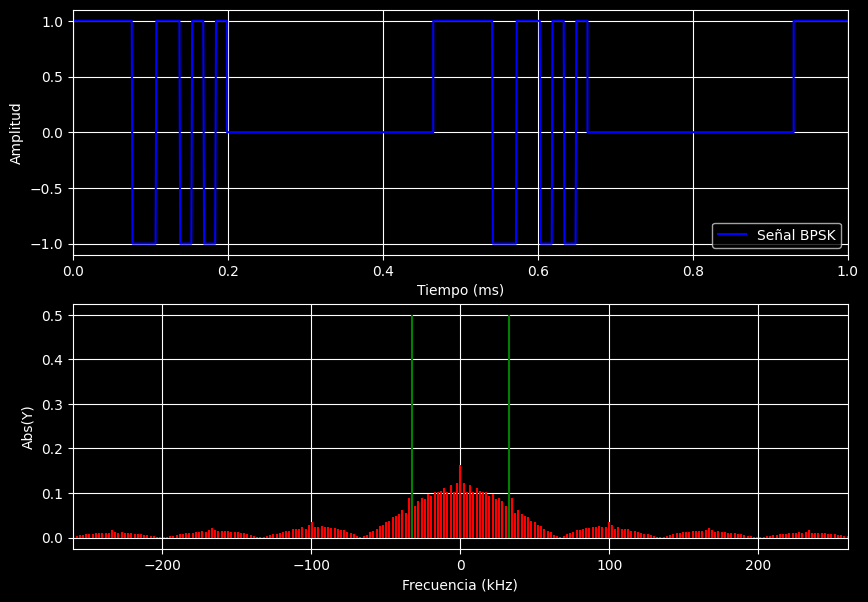

In [7]:
[senal2,t,fs] = Forma_Onda_Tx("Pulse_Cod","Barker_13",N,AB,PRF,T_pulso,Fc)

fs=1e6
ts = 1/fs # tiempo de muestreo


plt.figure(figsize = (10,7))
plt.subplot(211)
plt.xlim([0,1])
graficar_t(t,senal2.real,"Señal BPSK")

plt.subplot(212)
[Y,frq] = FFT(senal2,np.size(t),ts)
graficar_f(frq,Y,Fc,AB)

# MATRIZ CORRELACION

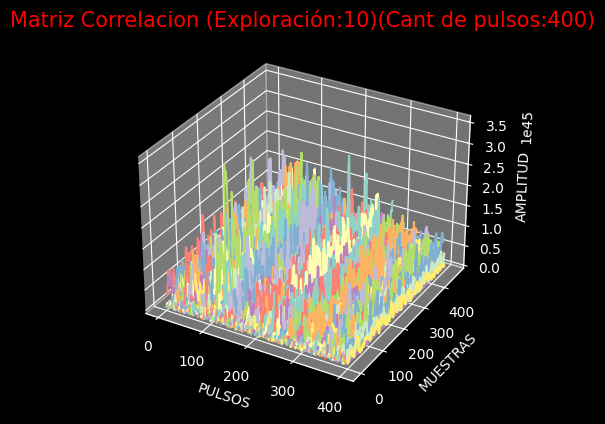

In [8]:
#-----------------------------------------------------------------------------------#
#####Define la exploracion#######
explr=10
##Cantidad de pulsos a graficar##
CantidadPulsos=400
#-----------------------------------------------------------------------------------#

# Crear datos para los ejes x, y, z
ejx = range(400) # PULSOS
ejy = range(466) # MUESTRAS
ejz = exploracion[explr][:] # señales

ts = 1/1e6 # tiempo de muestreo

# Configurar la figura y el eje 3D
plt.style.use("dark_background")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

correlacion_M = []

# Graficar
for i in range(CantidadPulsos):
    correlacion_M.append(signal.convolve(ejz[i],np.flip(senal2.conjugate()),"same","auto"))
    ax.plot(ejx[i]*np.ones_like(ejy), ejy, np.abs(correlacion_M[i]))


# Configurar etiquetas de los ejes
ax.set_xlabel('PULSOS')
ax.set_ylabel('MUESTRAS')
ax.set_zlabel('AMPLITUD')



plt.title('Matriz Correlacion (Exploración:'+str(explr)+')'+'(Cant de pulsos:'+str(CantidadPulsos)+')',color='red',fontsize=15)
plt.gca().spines[['top', 'right']].set_visible(False)

# Mostrar el gráfico
plt.show()

###prueba de que funciona>



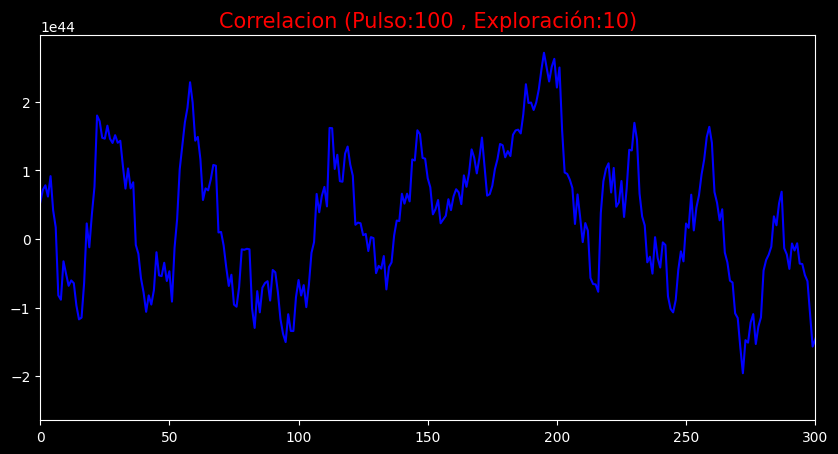

In [9]:
puls=100
plt.figure(figsize = (10,5))
plt.style.use("dark_background")
plt.title('Correlacion (Pulso:'+str(puls)+' , Exploración:'+str(explr)+')',color='red',fontsize=15)
plt.xlim([0,300])
plt.plot(ejy,correlacion_M[puls].real,color='blue')
plt.show()

# MATRIZ DOPPLER

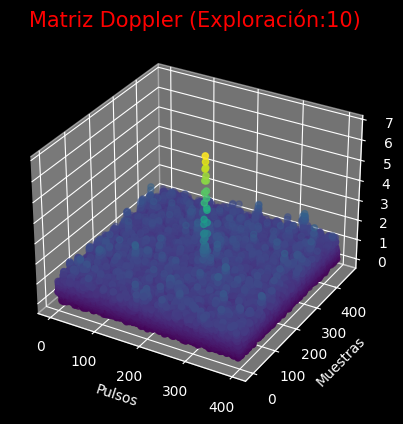

In [10]:
muestras=466
pulsos=400


# Crear datos para los ejes x, y, z
ejx = range(pulsos) # PULSOS
ejy = range(muestras) # MUESTRAS
ts = 1/1e6 # tiempo de muestreo


FFT_MATRIZ=[]

for i in range(muestras):
  FFT_MATRIZ.append([])
  for j in range(pulsos):
    FFT_MATRIZ[i].append(correlacion_M[j][i])
  FFT_MATRIZ[i]=abs(fftshift(fft(FFT_MATRIZ[i])))


# Crear coordenadas X e Y
X, Y = np.meshgrid(ejx, ejy)

#Eje z
Z=FFT_MATRIZ

# Graficar
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

surf = ax.scatter(X, Y, Z,c=Z,cmap='viridis')

ax.set_title('Matriz Doppler (Exploración:'+str(explr)+')',color='red',fontsize=15)
ax.set_ylabel('Muestras')
ax.set_xlabel('Pulsos')

###CAMBIAR LA VISTA
#ax.view_init(90, -90) #(90,-90)-->VISTA DESDE ARRIBA

plt.show()

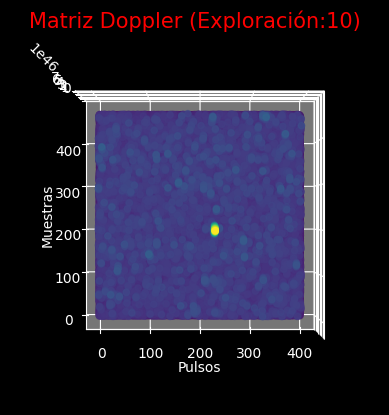

In [11]:
# Graficar
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

surf = ax.scatter(X, Y, Z,c=Z,cmap='viridis')

ax.set_title('Matriz Doppler (Exploración:'+str(explr)+')',color='red',fontsize=15)
ax.set_ylabel('Muestras')
ax.set_xlabel('Pulsos')

###CAMBIAR LA VISTA
ax.view_init(90, -90) #(90,-90)-->VISTA DESDE ARRIBA

plt.show()

EJES DE RANGO Y FRECUENCIA DOPPLER

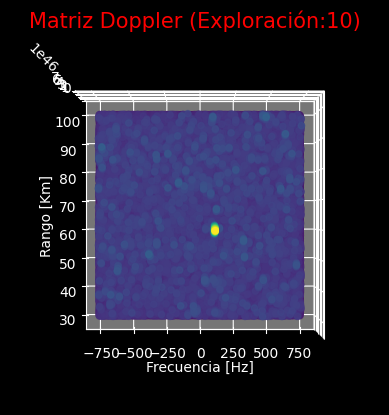

In [12]:
ts = 1/1e6 # tiempo de muestreo
TiempoPulso=0.2e-3 #[S]
RangoMinimo=int(round((3e8*TiempoPulso)/2))
eje_tiempo = np.linspace(0, (muestras - 1) * (ts), muestras) # TIEMPO [S]

eje_rango = (eje_tiempo*3e8)/2 + RangoMinimo # RANGO [m]
eje_frecuencia = fftshift(fftfreq(400,1/1.5e3)) # FRECUENCIA [Hz]

# Crear datos para los ejes x, y, z
ejx = eje_frecuencia # FRECUENCIA [Hz]
ejy=eje_rango*1e-3 # RANGO [Km]


# Crear coordenadas X e Y
X, Y = np.meshgrid(ejx, ejy)

# Graficar
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

surf = ax.scatter(X, Y, Z,c=Z,cmap='viridis')

ax.set_title('Matriz Doppler (Exploración:'+str(explr)+')',color='red',fontsize=15)
ax.set_ylabel('Rango [Km]')
ax.set_xlabel('Frecuencia [Hz]')

###CAMBIAR LA VISTA
ax.view_init(90, -90) #(90,-90)-->VISTA DESDE ARRIBA

plt.show()

# DETECCION DE OBJETIVO-FILTRO CFAR

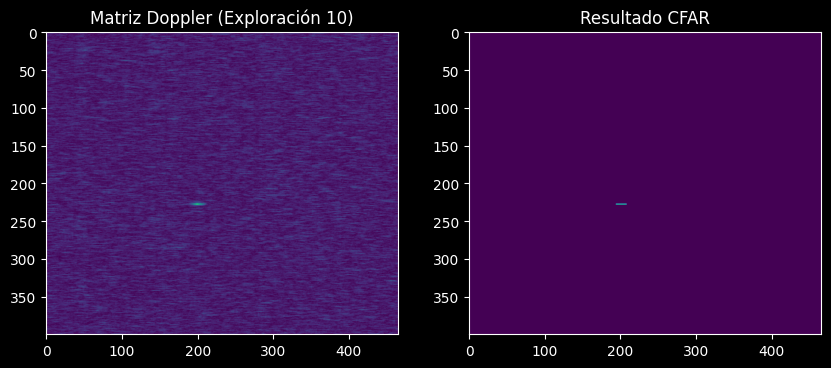

In [27]:

MATRIZ_DOPPLER=np.array(FFT_MATRIZ).T
data = MATRIZ_DOPPLER

# Parámetros del CFAR
guard_cells = 8
training_cells = 3
threshold_factor = 5

# Aplicar CFAR
cfar_result = cfar_2d(data, guard_cells, training_cells, threshold_factor)
cfar_result_umbral = cfar_2d_umbral(data, guard_cells, training_cells, threshold_factor)

# Mostrar resultados
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Matriz Doppler (Exploración '+str(explr)+')')
plt.imshow(data, cmap='viridis', interpolation='bilinear')
plt.subplot(1, 2, 2)
plt.title('Resultado CFAR')
plt.imshow(cfar_result, cmap='viridis', interpolation='bilinear')
plt.show()


UMBRAL ADAPTATIVO

Objetivo detectado en:
MUESTRA:  [199]
PULSO:  [228]


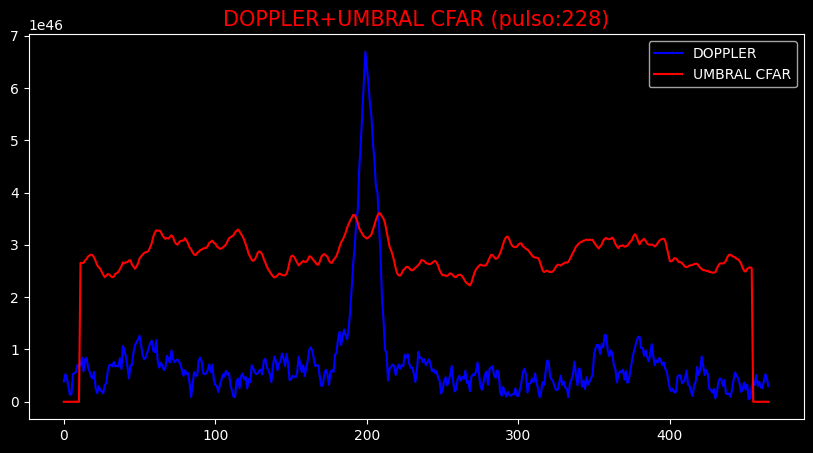

In [25]:
OBJETIVO=np.where(FFT_MATRIZ==np.amax(FFT_MATRIZ)) # Para verificar el umbral adaptativo
RANGO_OBJETIVO=OBJETIVO[0]
print("Objetivo detectado en:")
print("MUESTRA: ",RANGO_OBJETIVO)
FRECUENCIA_OBJETIVO=OBJETIVO[1]
print("PULSO: ",FRECUENCIA_OBJETIVO)

comp_pulso=FRECUENCIA_OBJETIVO[0]

plt.figure(figsize = (10,5))
plt.style.use("dark_background")
plt.title('DOPPLER+UMBRAL CFAR (pulso:'+str(comp_pulso)+')',color='red',fontsize=15)
plt.plot(range(466),MATRIZ_DOPPLER[comp_pulso],color='blue',label='DOPPLER')
plt.plot(range(466),cfar_result_umbral[comp_pulso],color='red',label='UMBRAL CFAR')
plt.legend(loc='best', facecolor='black', fontsize=10)
plt.show()

DETERMINACION DE MAXIMOS EN VARIOS OBJETIVOS

In [28]:

OBJETIVO=np.where(cfar_result==1)

RANGO_OBJETIVO=OBJETIVO[1]
print("Objetivo detectado en:")
print("RANGO(MUESTRA): ",RANGO_OBJETIVO)
FRECUENCIA_OBJETIVO=OBJETIVO[0]
print("FRECUENCIA(PULSO): ",FRECUENCIA_OBJETIVO)


PULSOS_V=[]

for i in range(len(FRECUENCIA_OBJETIVO)):
    if(i<len(FRECUENCIA_OBJETIVO)-1):
        if (FRECUENCIA_OBJETIVO[i]==FRECUENCIA_OBJETIVO[i+1]):
            PULSOS_V.append(FRECUENCIA_OBJETIVO[i])
        
            #print(PULSOS_V)
        else: 
           
            PULSOS_V.append(FRECUENCIA_OBJETIVO[i])
            ##------------
            #print(PULSOS_V[0])
            #print(RANGO_OBJETIVO[i+1-len(PULSOS_V):i+1])
            
            
            PULSO_CFAR=PULSOS_V[0]
            RANGO_CFAR=RANGO_OBJETIVO[i+1-len(PULSOS_V):i+1]
            RANGO_PICO=np.where(MATRIZ_DOPPLER[PULSOS_V[0]]==np.amax(MATRIZ_DOPPLER[PULSO_CFAR][RANGO_CFAR]))[0][0]
            print("RANGO(MUESTRA): ",RANGO_PICO)
            print("FRECUENCIA(PULSO): ",PULSO_CFAR)
           
            ##------------
            PULSOS_V=[]
    else: 
        PULSOS_V.append(FRECUENCIA_OBJETIVO[i])
        ##-------------
        #print(PULSOS_V[0])
        #print(RANGO_OBJETIVO[i+1-len(PULSOS_V):i+1])
        
        
        PULSO_CFAR=PULSOS_V[0]
        RANGO_CFAR=RANGO_OBJETIVO[i+1-len(PULSOS_V):i+1]
        RANGO_PICO=np.where(MATRIZ_DOPPLER[PULSOS_V[0]]==np.amax(MATRIZ_DOPPLER[PULSO_CFAR][RANGO_CFAR]))[0][0]
        print("RANGO(MUESTRA): ",RANGO_PICO)
        print("FRECUENCIA(PULSO): ",PULSO_CFAR)
           
        
        ##plt.plot(range(192,210),MATRIZ_DOPPLER[PULSOS_V[0]][i+1-len(PULSOS_V):i+1],color='blue')
        ##plt.plot(range(192,210),MATRIZ_DOPPLER[172][192:210],color='red')
        ##plt.show()
        ##-------------

Objetivo detectado en:
RANGO(MUESTRA):  [194 195 196 197 198 199 200 201 202 203 204 205 206 207]
FRECUENCIA(PULSO):  [228 228 228 228 228 228 228 228 228 228 228 228 228 228]
RANGO(MUESTRA):  199
FRECUENCIA(PULSO):  228


VERIFICACION PARA EL CASO DE VARIOS OBJETIVOS

In [29]:
#SIMULO EL CASO DE DETECCION DE 2 OBJETIVOS EN EL PULSO 2 Y 1 OBJETIVO EN LOS PULSOS 4 Y 5

matriz_unos=np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0]])


OBJETIVO=np.where(matriz_unos==1)

RANGO_OBJETIVO=OBJETIVO[1]
print("RANGO(MUESTRA): ",RANGO_OBJETIVO)
FRECUENCIA_OBJETIVO=OBJETIVO[0]
print("FRECUENCIA(PULSO): ",FRECUENCIA_OBJETIVO)
#plt.plot(range(len(matriz_unos[2])),matriz_unos[2],color='blue')
#plt.show()

PULSOS_V=[]

for i in range(len(FRECUENCIA_OBJETIVO)):
    if(i<len(FRECUENCIA_OBJETIVO)-1):
        if (FRECUENCIA_OBJETIVO[i]==FRECUENCIA_OBJETIVO[i+1]):
            PULSOS_V.append(FRECUENCIA_OBJETIVO[i])
        
            #print(PULSOS_V)
        else: 
           
            PULSOS_V.append(FRECUENCIA_OBJETIVO[i])
            ##------------
            #print(PULSOS_V[0])
            #print(RANGO_OBJETIVO[i+1-len(PULSOS_V):i+1])
            #print(RANGO_OBJETIVO[np.where(MATRIZ_DOPPLER[PULSOS_V[0]]==np.amax(MATRIZ_DOPPLER[PULSOS_V[0]][i+1-len(PULSOS_V):i+1]))])
            
            
            ##PULSO_CFAR=PULSOS_V[0]
            ##RANGO_CFAR=RANGO_OBJETIVO[np.where(MATRIZ_DOPPLER[PULSOS_V[0]]==np.amax(MATRIZ_DOPPLER[PULSOS_V[0]][i+1-len(PULSOS_V):i+1]))]
            ##print("RANGO(MUESTRA): ",RANGO_CFAR)
            ##print("FRECUENCIA(PULSO): ",PULSO_CFAR)
           
            ##------------
            PULSOS_V=[]
    else: 
        PULSOS_V.append(FRECUENCIA_OBJETIVO[i])
        ##-------------
        #print(PULSOS_V[0])
        #print(RANGO_OBJETIVO[i+1-len(PULSOS_V):i+1])
        #print(MATRIZ_DOPPLER[PULSOS_V[0]][i+1-len(PULSOS_V):i+1])
        #print(np.amax(MATRIZ_DOPPLER[PULSOS_V[0]][i+1-len(PULSOS_V):i+1]))
        #print(RANGO_OBJETIVO[np.where(MATRIZ_DOPPLER[PULSOS_V[0]]==np.amax(MATRIZ_DOPPLER[PULSOS_V[0]][i+1-len(PULSOS_V):i+1]))])
        
        
        
        ##PULSO_CFAR=PULSOS_V[0]
        ##RANGO_CFAR=RANGO_OBJETIVO[np.where(MATRIZ_DOPPLER[PULSOS_V[0]]==np.amax(MATRIZ_DOPPLER[PULSOS_V[0]][i+1-len(PULSOS_V):i+1]))]
        ##print("RANGO(MUESTRA): ",RANGO_CFAR)
        ##print("FRECUENCIA(PULSO): ",PULSO_CFAR)
        ##print(str(i+1-len(PULSOS_V)))
        ##print(str(i+1))
        
        ##plt.plot(range(192,210),MATRIZ_DOPPLER[PULSOS_V[0]][i+1-len(PULSOS_V):i+1],color='blue')
        ##plt.plot(range(192,210),MATRIZ_DOPPLER[172][192:210],color='red')
        ##plt.show()
        ##-------------

RANGO(MUESTRA):  [ 4  5  6  7 18 19 20 21 22 11 12 13 14 23 24 25]
FRECUENCIA(PULSO):  [2 2 2 2 2 2 2 2 2 4 4 4 4 5 5 5]


RANGO DE DETECCIONES CFAR

RANGO(MUESTRA):  [194 195 196 197 198 199 200 201 202 203 204 205 206 207]
FRECUENCIA(PULSO):  [228 228 228 228 228 228 228 228 228 228 228 228 228 228]


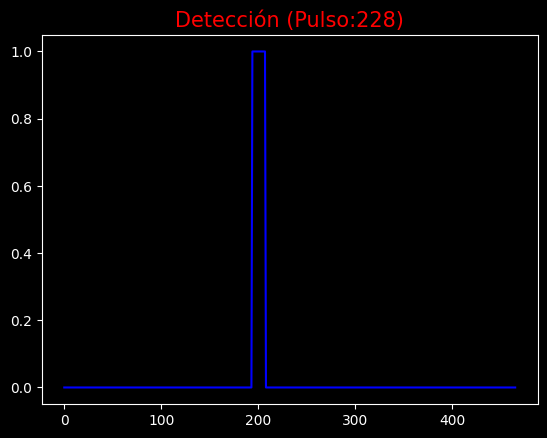

In [33]:
OBJETIVO=np.where(cfar_result==1)
RANGO_OBJETIVO=OBJETIVO[1]
print("RANGO(MUESTRA): ",RANGO_OBJETIVO)
FRECUENCIA_OBJETIVO=OBJETIVO[0]
print("FRECUENCIA(PULSO): ",FRECUENCIA_OBJETIVO)
plt.plot(range(466),cfar_result[comp_pulso],color='blue')
plt.title('Detección (Pulso:'+str(comp_pulso)+')',color='red',fontsize=15)
plt.show()

# RANGO Y VELOCIDAD

In [35]:
RANGO=ejy[RANGO_PICO]
VELOCIDAD_RADIAL=((eje_frecuencia[PULSO_CFAR]*3e8)/(1e9*2))*3.6 #[Km/h]
print("Objetivo detectado a: "+str(RANGO)+" Km")
print("Velocidad radial: "+str(VELOCIDAD_RADIAL)+" Km/h")
print("Frecuencia Doppler: "+str(eje_frecuencia[PULSO_CFAR])+" Hz")

Objetivo detectado a: 59.85 Km
Velocidad radial: 56.7 Km/h
Frecuencia Doppler: 105.0 Hz


# GUARDADO DE IMAGENES

In [36]:

CantidadPulsos=400
VECTOR_MUESTRAS=[]
VECTOR_PULSOS=[]
for explr in range(20):

  # Crear datos para los ejes x, y, z
  ejx = range(400) # PULSOS
  ejy = range(466) # MUESTRAS
  ejz = exploracion[explr][:] # señales

  ts = 1/1e6 # tiempo de muestreo

  correlacion_M = []

  # Graficar
  for i in range(CantidadPulsos):
      correlacion_M.append(signal.convolve(ejz[i],np.flip(senal2.conjugate()),"same","auto"))



 ####MATRIZ DOPPLER

  muestras=466
  pulsos=400


  # Crear datos para los ejes x, y, z
  ejx = range(pulsos) # PULSOS
  ejy = range(muestras) # MUESTRAS
  ts = 1/1e6 # tiempo de muestreo


  FFT_MATRIZ=[]

  for i in range(muestras):
   FFT_MATRIZ.append([])
   for j in range(pulsos):
      FFT_MATRIZ[i].append(correlacion_M[j][i])
   FFT_MATRIZ[i]=abs(fftshift(fft(FFT_MATRIZ[i])))


# Crear coordenadas X e Y
  X, Y = np.meshgrid(ejx, ejy)

#Eje z
  Z=FFT_MATRIZ

# Graficar
  #fig = plt.figure()
  #ax = fig.add_subplot(projection='3d')

  #surf = ax.scatter(X, Y, Z,c=Z,cmap='viridis')

  #ax.set_title('Matriz Doppler (Exploración:'+str(explr)+')',color='red',fontsize=15)
  #ax.set_ylabel('Muestras')
  #ax.set_xlabel('Pulsos')


##GUARDA LA MATRIZ DOPPLER

  #GUARDAR IMAGENES
  #directorio='/content/drive/MyDrive/Facultad/Img_radar'
  #plt.savefig(directorio+'/MATRIZ_D'+'_Exploracion_'+str(explr)+'.png')


##VISTA DE ARRIBA
  ts = 1/1e6 # tiempo de muestreo
  TiempoPulso=0.2e-3 #[S]
  RangoMinimo=int(round((3e8*TiempoPulso)/2))
  eje_tiempo = np.linspace(0, (muestras - 1) * (ts), muestras) # TIEMPO [S]

  eje_rango = (eje_tiempo*3e8)/2 + RangoMinimo # RANGO [m]
  eje_frecuencia = fftshift(fftfreq(400,1/1.5e3)) # FRECUENCIA [Hz]

# Crear datos para los ejes x, y, z
  ejx = eje_frecuencia # FRECUENCIA [Hz]
  ejy=eje_rango*1e-3 # RANGO [Km]


# Crear coordenadas X e Y
  ##X, Y = np.meshgrid(ejx, ejy)

# Graficar
  ##fig = plt.figure()
  ##ax = fig.add_subplot(projection='3d')

  ##surf = ax.scatter(X, Y, Z,c=Z,cmap='viridis')

  ##ax.set_title('Matriz Doppler (Exploración:'+str(explr)+')',color='red',fontsize=15)
  ##ax.set_ylabel('Rango [Km]')
  ##ax.set_xlabel('Frecuencia [Hz]')

###CAMBIAR LA VISTA
  ##ax.view_init(90, -90) #(90,-90)-->VISTA DESDE ARRIBA
  #directorio='/content/drive/MyDrive/Facultad/Img_radar'
  ##directorio='IMAGENES'
  ##plt.savefig(directorio+'\MATRIZ_DA'+'_Exploracion_'+str(explr)+'.png')
  #plt.show()

###VECTOR QUE ALMACENA EL RANGO Y FRECUENCIA
  print("----------EXPLORACION "+str(explr)+"-----------")
  OBJETIVO=np.where(FFT_MATRIZ==np.amax(FFT_MATRIZ))
  RANGO_OBJETIVO=OBJETIVO[0]
  print("RANGO(MUESTRA): ",RANGO_OBJETIVO)
  FRECUENCIA_OBJETIVO=OBJETIVO[1]
  print("FRECUENCIA(PULSO): ",FRECUENCIA_OBJETIVO)
  RANGO=ejy[RANGO_OBJETIVO]
  VELOCIDAD_RADIAL=((eje_frecuencia[FRECUENCIA_OBJETIVO]*3e8)/(1e9*2))*3.6 #[Km/h]
  print("Objetivo detectado a: "+str(RANGO)+" Km")
  print("Velocidad radial: "+str(VELOCIDAD_RADIAL)+" Km/h")
  print("----------------------------------")
  print("\n")
  VECTOR_MUESTRAS.append(OBJETIVO[0])
  VECTOR_PULSOS.append(OBJETIVO[1])


----------EXPLORACION 0-----------
RANGO(MUESTRA):  [201]
FRECUENCIA(PULSO):  [172]
Objetivo detectado a: [60.15] Km
Velocidad radial: [-56.7] Km/h
----------------------------------


----------EXPLORACION 1-----------
RANGO(MUESTRA):  [199]
FRECUENCIA(PULSO):  [178]
Objetivo detectado a: [59.85] Km
Velocidad radial: [-44.55] Km/h
----------------------------------


----------EXPLORACION 2-----------
RANGO(MUESTRA):  [198]
FRECUENCIA(PULSO):  [185]
Objetivo detectado a: [59.7] Km
Velocidad radial: [-30.375] Km/h
----------------------------------


----------EXPLORACION 3-----------
RANGO(MUESTRA):  [197]
FRECUENCIA(PULSO):  [188]
Objetivo detectado a: [59.55] Km
Velocidad radial: [-24.3] Km/h
----------------------------------


----------EXPLORACION 4-----------
RANGO(MUESTRA):  [196]
FRECUENCIA(PULSO):  [196]
Objetivo detectado a: [59.4] Km
Velocidad radial: [-8.1] Km/h
----------------------------------


----------EXPLORACION 5-----------
RANGO(MUESTRA):  [197]
FRECUENCIA(PULSO)

# BUCLE EXPLORACIONES

In [35]:

muestras=466
pulsos=400
VECTOR_MUESTRAS=[]
VECTOR_PULSOS=[]
for explr in range(20):

  # Crear datos para los ejes x, y, z
  ejx = range(pulsos) # PULSOS
  ejy = range(muestras) # MUESTRAS
  ejz = exploracion[explr][:] # señales

  

  ####MATRIZ CORRELACION
  correlacion_M = []

  
  for i in range(pulsos):
      correlacion_M.append(signal.convolve(ejz[i],np.flip(senal2.conjugate()),"same","auto"))


  ####MATRIZ DOPPLER
  FFT_MATRIZ=[]

  for i in range(muestras):
   FFT_MATRIZ.append([])
   for j in range(pulsos):
      FFT_MATRIZ[i].append(correlacion_M[j][i])
   FFT_MATRIZ[i]=abs(fftshift(fft(FFT_MATRIZ[i])))
  
  
  ts = 1/1e6 # tiempo de muestreo
  TiempoPulso=0.2e-3 #[S]
  RangoMinimo=int(round((3e8*TiempoPulso)/2))
  eje_tiempo = np.linspace(0, (muestras - 1) * (ts), muestras) # TIEMPO [S]
  eje_rango = (eje_tiempo*3e8)/2 + RangoMinimo # RANGO [m]
  eje_frecuencia = fftshift(fftfreq(400,1/1.5e3)) # FRECUENCIA [Hz]

  # Crear datos para los ejes x, y
  ejx = eje_frecuencia # FRECUENCIA [Hz]
  ejy=eje_rango*1e-3 # RANGO [Km]


#   # Crear coordenadas X e Y
#   X, Y = np.meshgrid(ejx, ejy)
#   # Eje z
#   Z=FFT_MATRIZ

#   # Graficar
#   fig = plt.figure()
#   ax = fig.add_subplot(projection='3d')

#   surf = ax.scatter(X, Y, Z,c=Z,cmap='viridis')

#   ax.set_title('Matriz Doppler (Exploración:'+str(explr)+')',color='red',fontsize=15)
#   ax.set_ylabel('Rango [Km]')
#   ax.set_xlabel('Frecuencia [Hz]')

#   ###CAMBIAR LA VISTA
#   ax.view_init(90, -90) #(90,-90)-->VISTA DESDE ARRIBA
 
#   plt.show()


  ###VECTOR QUE ALMACENA EL RANGO Y FRECUENCIA

  MATRIZ_DOPPLER=np.array(FFT_MATRIZ).T

  data = MATRIZ_DOPPLER

  # Parámetros del CFAR
  guard_cells = 8
  training_cells = 3
  threshold_factor = 5

  # Aplicar CFAR
  print("----------EXPLORACION "+str(explr)+"-----------")
  cfar_result = cfar_2d(data, guard_cells, training_cells, threshold_factor)

  OBJETIVO=np.where(cfar_result==1)

  RANGO_OBJETIVO=OBJETIVO[1]

  FRECUENCIA_OBJETIVO=OBJETIVO[0]
  
  

  PULSOS_V=[]

  for i in range(len(FRECUENCIA_OBJETIVO)):
    if(i<len(FRECUENCIA_OBJETIVO)-1):
        if (FRECUENCIA_OBJETIVO[i]==FRECUENCIA_OBJETIVO[i+1]):
            PULSOS_V.append(FRECUENCIA_OBJETIVO[i])
        
            
        else: 
           
            PULSOS_V.append(FRECUENCIA_OBJETIVO[i])
            ##------------
            
            PULSO_CFAR=PULSOS_V[0]
            RANGO_CFAR=RANGO_OBJETIVO[i+1-len(PULSOS_V):i+1]
            RANGO_PICO=np.where(MATRIZ_DOPPLER[PULSOS_V[0]]==np.amax(MATRIZ_DOPPLER[PULSO_CFAR][RANGO_CFAR]))[0][0]
            RANGO=ejy[RANGO_PICO]
            VELOCIDAD_RADIAL=((eje_frecuencia[PULSO_CFAR]*3e8)/(1e9*2))*3.6 #[Km/h]
            print("RANGO(MUESTRA): ",RANGO_PICO)
            print("FRECUENCIA(PULSO): ",PULSO_CFAR)
            print("Objetivo detectado a: "+str(round(RANGO,2))+" Km")
            print("Velocidad radial: "+str(round(VELOCIDAD_RADIAL,2))+" Km/h")
  
            ##------------
            PULSOS_V=[]
    else: 
        PULSOS_V.append(FRECUENCIA_OBJETIVO[i])
        ##-------------

        PULSO_CFAR=PULSOS_V[0]
        RANGO_CFAR=RANGO_OBJETIVO[i+1-len(PULSOS_V):i+1]
        RANGO_PICO=np.where(MATRIZ_DOPPLER[PULSOS_V[0]]==np.amax(MATRIZ_DOPPLER[PULSO_CFAR][RANGO_CFAR]))[0][0]
        RANGO=ejy[RANGO_PICO]
        VELOCIDAD_RADIAL=((eje_frecuencia[PULSO_CFAR]*3e8)/(1e9*2))*3.6 #[Km/h]
        print("RANGO(MUESTRA): ",RANGO_PICO)
        print("FRECUENCIA(PULSO): ",PULSO_CFAR)
        print("Objetivo detectado a: "+str(round(RANGO,2))+" Km")
        print("Velocidad radial: "+str(round(VELOCIDAD_RADIAL,2))+" Km/h")

        ##-------------
  
  print("----------------------------------")
  print("\n")
  
  




----------EXPLORACION 0-----------
RANGO(MUESTRA):  201
FRECUENCIA(PULSO):  172
Objetivo detectado a: 60.15 Km
Velocidad radial: -56.7 Km/h
----------------------------------


----------EXPLORACION 1-----------
RANGO(MUESTRA):  199
FRECUENCIA(PULSO):  178
Objetivo detectado a: 59.85 Km
Velocidad radial: -44.55 Km/h
----------------------------------


----------EXPLORACION 2-----------
RANGO(MUESTRA):  198
FRECUENCIA(PULSO):  185
Objetivo detectado a: 59.7 Km
Velocidad radial: -30.38 Km/h
----------------------------------


----------EXPLORACION 3-----------
RANGO(MUESTRA):  197
FRECUENCIA(PULSO):  188
Objetivo detectado a: 59.55 Km
Velocidad radial: -24.3 Km/h
----------------------------------


----------EXPLORACION 4-----------
RANGO(MUESTRA):  196
FRECUENCIA(PULSO):  196
Objetivo detectado a: 59.4 Km
Velocidad radial: -8.1 Km/h
----------------------------------


----------EXPLORACION 5-----------
RANGO(MUESTRA):  197
FRECUENCIA(PULSO):  201
Objetivo detectado a: 59.55 Km
Veloc

# GRAFICAS ANIMADAS

In [37]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
#from IPython.display import HTML 

MovieWriter ffmpeg unavailable; using Pillow instead.


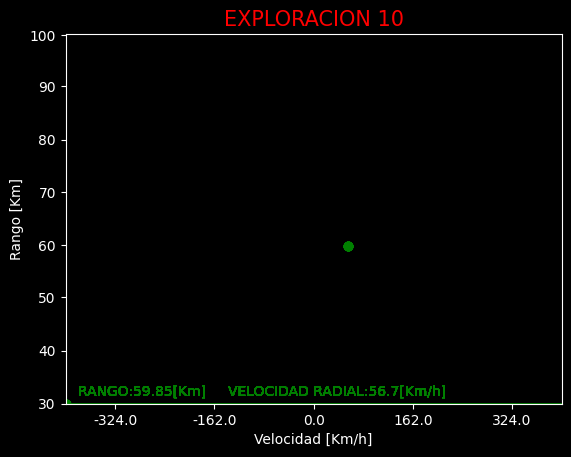

In [41]:


explora=10
muestras=466
pulsos=400
pos=VECTOR_MUESTRAS[explora][0]
vel=VECTOR_PULSOS[explora][0]
RANGOO=ejy[pos]
VELOCIDAD_RADIAL=((eje_frecuencia[vel]*3e8)/(1e9*2))*3.6 #[Km/h]


# Función para actualizar la gráfica en cada fotograma de la animación
def update(frame):

  y_value = frame * 1  # Avanzar la línea horizontal cada 1 unidades de y
  line.set_ydata([y_value])  # Cambia la posición y de la línea verde

    # Verificar si la línea pasa por y
  if y_value > pos:
      points.append((vel, pos))  # Agregar punto en x=vel, y=pos
      ax.text(10,10,"RANGO:"+str(round(RANGOO,3))+"[Km] "+"    VELOCIDAD RADIAL:"+str(round(VELOCIDAD_RADIAL,3))+"[Km/h]",color="green")
  else: points.append((0, 0))


  # Actualizar la posición de los puntos
  point_plot.set_data(zip(*points))
  # Actualizar la posición de la línea
  line.set_data([0, muestras], [y_value, y_value])
  



# Configuración inicial de la gráfica
fig, ax = plt.subplots()
ax.set_xlim(0, 400)
ax.set_ylim(0, 466)
line, = ax.plot([], [], lw=2, color='green')  # Línea horizontal verde
points = []  # Lista para almacenar los puntos
point_plot, = ax.plot([], [], 'go')  # Inicializar la gráfica de puntos

# Creación de la animación
plt.style.use('dark_background')
plt.title('EXPLORACION '+str(explora),color='red',fontsize=15)

plt.xticks([40,120,200,280,360],[eje_frecuencia[40]*(3e8*3.6)/(1e9*2),
eje_frecuencia[120]*(3e8*3.6)/(1e9*2),eje_frecuencia[200]*(3e8*3.6)/(1e9*2),
eje_frecuencia[280]*(3e8*3.6)/(1e9*2),eje_frecuencia[360]*(3e8*3.6)/(1e9*2)])

plt.yticks([0,67,134,200,267,333,400,465],[30,40,50,60,70,80,90,100])
ax.set_ylabel('Rango [Km]')
ax.set_xlabel('Velocidad [Km/h]')

ani = FuncAnimation(fig, update, frames=range(0, 466,10), interval=5) #INTERVAL 5

ani.save("ANIM_EXPL_"+str(explora)+".gif")

#plt.show()
# Mostrar la animación en Colab
#HTML(ani.to_html5_video())





!["ANIM_EXPL_10.gif"](ANIM_EXPL_10.gif)

## TRAYECTORIA

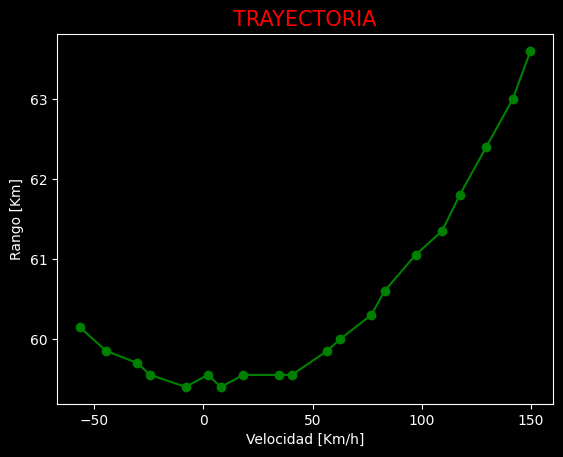

In [42]:


# GRAFICA DE TRAYECTORIA
fig,ax = plt.subplots()
plt.style.use('dark_background')
plt.title('TRAYECTORIA',color='red',fontsize=15)



plt.plot(((eje_frecuencia[VECTOR_PULSOS]*3e8)/(1e9*2))*3.6,ejy[VECTOR_MUESTRAS],'-go')
ax.set_ylabel('Rango [Km]')
ax.set_xlabel('Velocidad [Km/h]')
plt.show()



MovieWriter ffmpeg unavailable; using Pillow instead.


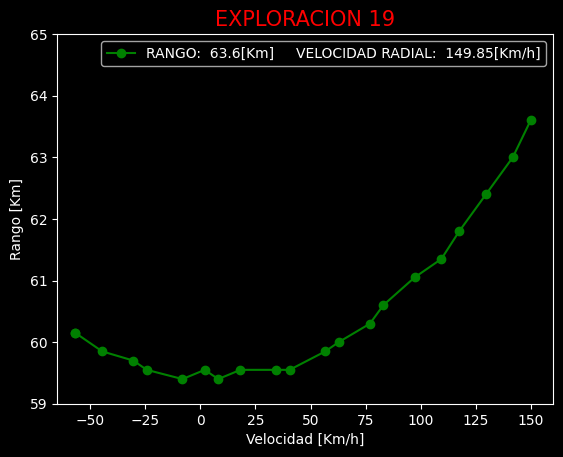

In [44]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
#from IPython.display import HTML 


# Función para actualizar la gráfica en cada fotograma de la animación
def update(frame):
  

  EXPLORA=frame
  
  pos=VECTOR_MUESTRAS[EXPLORA][0]
  vel=VECTOR_PULSOS[EXPLORA][0]
  RANGOO=ejy[pos]
  VELOCIDAD_RADIAL=((eje_frecuencia[vel]*3e8)/(1e9*2))*3.6 #[Km/h]
 
  plt.title('EXPLORACION '+str(EXPLORA),color='red',fontsize=15)
  points.append((VELOCIDAD_RADIAL, RANGOO))  # Agregar punto en x=vel, y=pos
  #ax.text(-50,64,"RANGO:"+str(round(RANGOO,3))+"[Km] "+"    VELOCIDAD RADIAL:"+str(round(VELOCIDAD_RADIAL,3))+"[Km/h]",color="green")
  
 
  

  # Actualizar la posición de los puntos
  point_plot.set_data(zip(*points))
  point_plot.set_label("RANGO:  "+str(round(RANGOO,3))+"[Km] "+"    VELOCIDAD RADIAL:  "+str(round(VELOCIDAD_RADIAL,3))+"[Km/h]")
  plt.legend(loc='best', facecolor='black', fontsize=10)
  
  

# Configuración inicial de la gráfica
fig=plt.figure()
ax = fig.gca()
ax.set_xlim(-65, 160)
ax.set_ylim(59, 65)
line, = ax.plot([], [], lw=2, color='green')  # Línea horizontal verde
points = []  # Lista para almacenar los puntos
point_plot, = ax.plot([], [], '-go')  # Inicializar la gráfica de puntos

# Creación de la animación
plt.style.use('dark_background')


ax.set_ylabel('Rango [Km]')
ax.set_xlabel('Velocidad [Km/h]')

ani = FuncAnimation(fig, update, frames=range(0, 20), interval=1000) #INTERVAL 5

ani.save('ANIM_EXPLORACIONES.gif')
plt.show()
# Mostrar la animación en Colab
#HTML(ani.to_html5_video())


!['ANIM_EXPLORACIONES.gif'](ANIM_EXPLORACIONES.gif)

MovieWriter ffmpeg unavailable; using Pillow instead.


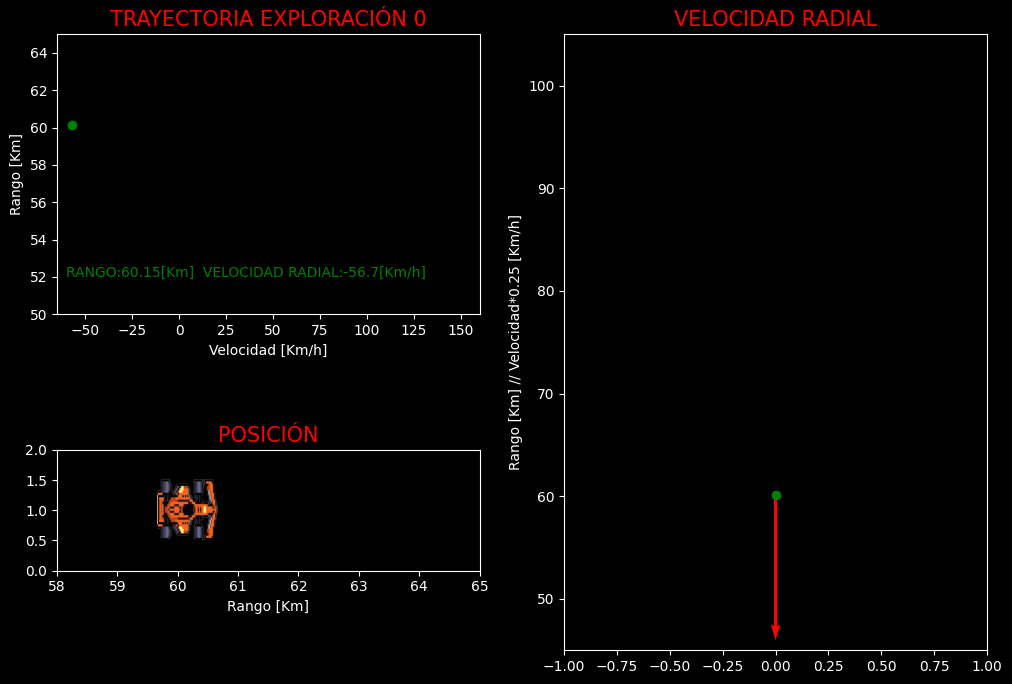

In [57]:

VECTOR_MUESTRAS_COPIA=[201,199, 198, 197, 196, 197, 196, 197, 197, 197, 199, 200, 202, 204, 207, 209, 212, 216, 220, 224]
VECTOR_PULSOS_COPIA = [172, 178, 185, 188, 196, 201, 204, 209, 217, 220, 228, 231, 238, 241, 248, 254, 258, 264, 270, 274]


car_img=mpimg.imread('F1.png')
muestras=466
ts = 1/1e6 # tiempo de muestreo
TiempoPulso=0.2e-3 #[S]
RangoMinimo=int(round((3e8*TiempoPulso)/2))
eje_tiempo = np.linspace(0, (muestras - 1) * (ts), muestras) # TIEMPO [S]

eje_rango = (eje_tiempo*3e8)/2 + RangoMinimo # RANGO [m]
eje_frecuencia = fftshift(fftfreq(400,1/1.5e3)) # FRECUENCIA [Hz]

# Crear datos para los ejes x, y, z
ejx = eje_frecuencia # FRECUENCIA [Hz]
ejy=eje_rango*1e-3 # RANGO [Km]



def update(frame):
   
  
  plt.subplot(221).cla()
  plt.subplot(2,2,(2,4)).cla()
  plt.subplot(223).cla()
  
  plt.style.use("dark_background")
  
  
  #plt.title('TRAYECTORIA EXPLORACION '+str(EXPLORA),color='red',fontsize=15)
  EXPLORA=frame
 

  pos=VECTOR_MUESTRAS_COPIA[EXPLORA]
  vel=VECTOR_PULSOS_COPIA[EXPLORA]
  RANGOO=ejy[pos]
  VELOCIDAD_RADIAL=((eje_frecuencia[vel]*3e8)/(1e9*2))*3.6 #[Km/h]

  
  
  plt.subplot(2,2,1)
  plt.xlim([-65,160])
  plt.ylim([50,65])
  plt.plot(((eje_frecuencia[VECTOR_PULSOS_COPIA[EXPLORA]]*3e8)/(1e9*2))*3.6,ejy[VECTOR_MUESTRAS_COPIA[EXPLORA]],'go')#,label="RANGO:  "+str(round(RANGOO,3))+"[Km] "+"    VELOCIDAD RADIAL:  "+str(round(VELOCIDAD_RADIAL,3))+"[Km/h]")
  plt.ylabel('Rango [Km]')
  plt.xlabel('Velocidad [Km/h]')
  #plt.legend(loc='best', facecolor='black')
  plt.title('TRAYECTORIA EXPLORACIÓN '+str(EXPLORA),color='red',fontsize=15)
  plt.text(-60,52,"RANGO:"+str(round(RANGOO,3))+"[Km] "+" VELOCIDAD RADIAL:"+str(round(VELOCIDAD_RADIAL,3))+"[Km/h]",color="green")
  


  plt.subplot(2,2,(2,4))
  plt.xlim(-1,1)
  plt.ylim(45,105)
  #plt.quiver(0,0,0,RANGOO,scale_units='xy',angles='xy',scale=1,color='green')
  plt.plot(0,RANGOO,'go')
  plt.quiver(0,RANGOO,0,VELOCIDAD_RADIAL*0.25,scale_units='xy',angles='xy',scale=1,color='red')
  plt.ylabel('Rango [Km] // Velocidad*0.25 [Km/h]')
  plt.title('VELOCIDAD RADIAL',color='red',fontsize=15)
  
  
  plt.subplot(2,2,3)
  x=ejy[VECTOR_MUESTRAS_COPIA[EXPLORA]]
  y=1
  plt.xlim([58,65])
  plt.ylim([0,2])
  plt.imshow(car_img,extent=(x-0.5,x+0.5,y-0.5,y+0.5))
  plt.xlabel('Rango [Km]')
  plt.title('POSICIÓN',color='red',fontsize=15)
  
  


fig= plt.figure(figsize=(12,8)) 

plt.axis('off')


ani = FuncAnimation(fig, update, frames=range(0, 20), interval=1000) 


ani.save('ANIMACION_PLOTS.gif')





!['ANIMACION_PLOTS.gif'](ANIMACION_PLOTS.gif)
